In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats

from qbitmap import simulated_annealer
from qbitmap import utils
from qbitmap import io
from qbitmap import noisemap 

### State space analysis

Here we analyze some metrics that we would otherwise like to observe in hardware to demonstrate good potential for SA.

In [22]:
def make_anneal_name(circuit_name, n_qubits, path="./results"):
    pre = f"{circuit_name}_n{n_qubits}_"
    anneal_fname = pre + "anneal_results.npy"
    return os.path.join(path, anneal_fname)

Consider the following schedules

\begin{align}
T_{exp}(t) &= T(0) \alpha^t  \\
T_{log}(t) &= \frac{T(0)}{1 + \alpha \log(1 + t) } \\
T_{poly}(t) &= \frac{T(0)}{1 + \alpha t^p} \\
\end{align}

In [23]:
def T_exp(T0, alpha, steps):
    t = np.arange(steps)
    return T0 * alpha ** t

def T_log(T0, alpha, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * np.log(1 + t))

def T_lin(T0, steps):
    t = np.linspace(0, 1, steps)
    return T0 * (1 - t)

def T_poly(T0, alpha, p, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * t ** p)

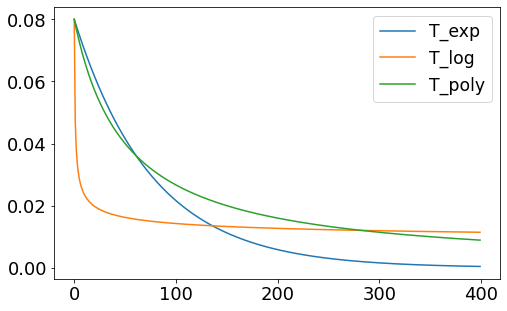

In [24]:
T0 = 0.08
# alpha = 0.98
p = 1
anneal_steps = 400

temps1 = T_exp(T0, 0.987, anneal_steps)
temps2 = T_log(T0, 1, anneal_steps)
temps3 = T_poly(T0, .02, p, anneal_steps)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(anneal_steps), temps1, label="T_exp")
ax.plot(range(anneal_steps), temps2, label="T_log")
ax.plot(range(anneal_steps), temps3, label="T_poly")
ax.legend(loc="upper right")

In [26]:
## Simulation hyperparameters
NUM_NEW_MAX = 2
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)


# Use pre-optimized SA params
anneal_steps = 400
T0 = 0.08
# log_temp = T_log(0.08, 1, anneal_steps)
exp_temp = T_exp(T0, 0.987, anneal_steps)

seeds = list(range(10))


## SIMULATIONS COMPLETE. DO NOT RUN.

In [13]:
# Load in the noise graph just for connectivity info
tag = "contrived"
noise_graph = nx.read_gpickle(f"./results/{tag}_noisemap.pkl")

In [ ]:
metric_results = results

trials = 20
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)
num_new_max_lst = [1, 2, 3]
temps_lst = [temps1, temps2, temps3]

all_results = [ [ None for _ in range(3)] for _ in range(3)]
all_state_counts = np.zeros((3, 3, trials))

for i, num_new_max in enumerate(num_new_max_lst):
    print("num_new_max= ", i)
    for j, temp in enumerate(temps_lst):
        print("temps= ", j)
        ann_results = []
        for ell in range(trials):
            idx_state = np.random.choice(len(all_paths))
            initial_state = all_paths[idx_state]
            annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
                initial_state=initial_state,
                paths=all_paths,
                fidelities=metric_results[:,1],
                graph=noise_graph,
                num_new_max=num_new_max,
                transition_probs=TRANSITION_PROBS,
                verbose=False
            )
            res, history = annealer.anneal(nsteps=anneal_steps, temperatures=temp)
            ann_results.append(history)
            all_state_counts[i,j,ell] = history['unique_states_counter'][-1]

        results_arr = np.zeros((trials, anneal_steps + 1))
        for k, res in enumerate(ann_results):
            results_arr[k,:] = res['score_history']
        all_results[i][j] = results_arr

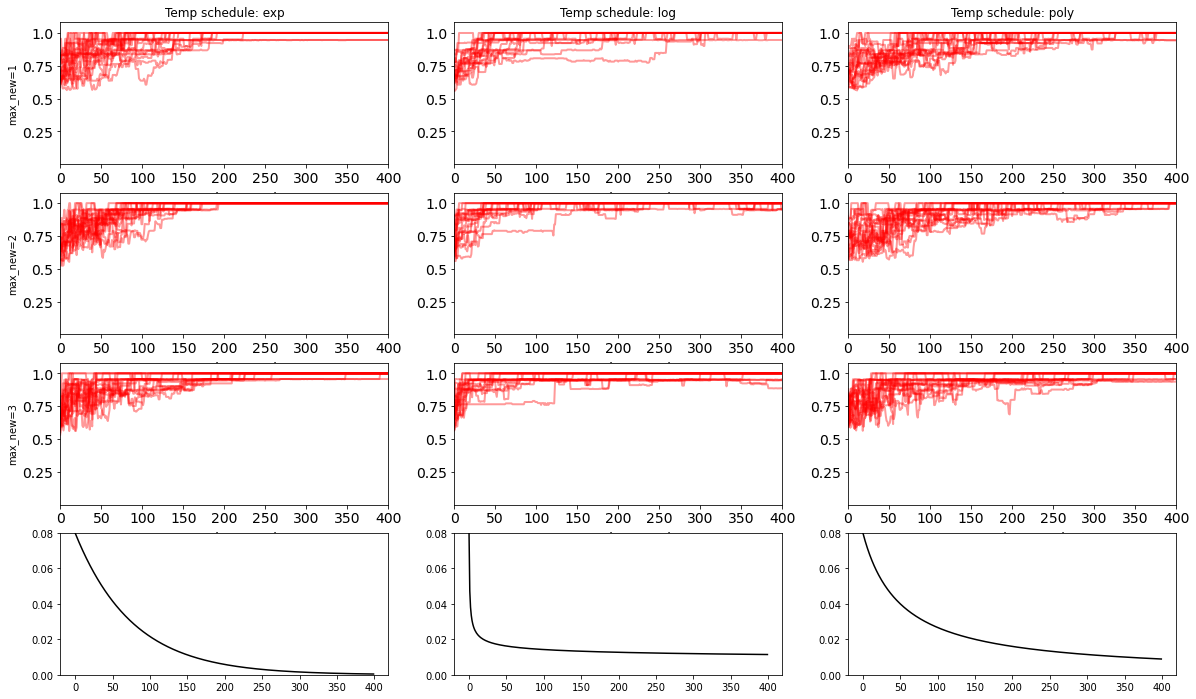

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12))

num_new_max_lst = [1, 2, 3]
temps_lst = [temps1, temps2, temps3]
best_score = max(metric_results[:,1])
num_new_max = [1,2,3]
temp_labs = ["exp", "log", "poly"]
for i in range(4):
    for j in range(3):
        ax = axes[i, j]
        if i == 3:
            y = temps_lst[j]
            ax.plot(range(len(y)), y, c='k')
            ax.set_ylim(0, T0)
            continue
        results_arr = all_results[i][j]
        for k,res in enumerate(results_arr):
            ax.plot(range(anneal_steps+1), results_arr[k,:] / best_score, lw=2, alpha=0.4, c='r')

        if j == 0:
            ax.set_ylabel("max_new={}".format(num_new_max[i]))
        if i == 0:
            ax.set_title("Temp schedule: {}".format(temp_labs[j]))
#         ax.plot(range(anneal_steps), temps / max(temps), linewidth=1, c='k', ls=':')
        ax.set_xlim(-2, anneal_steps+2)
        ax.set_xticks(range(0, anneal_steps+1, 50))
        ax.set_xticklabels(range(0, anneal_steps+1, 50), fontsize=14)
        ax.set_xlabel('Annealer step $i$', fontsize=14)

        ax.set_ylim(0, 1.08)
        ax.set_xlim(0, anneal_steps)
        ax.set_yticks([.25, .5, .75, 1.])
        ax.set_yticklabels([.25, .5, .75, 1.], fontsize=14)

In [ ]:
# Run the SA over many trials and average the performance
ntrials_anneal = 500
anneal_outcomes = np.zeros((ntrials_anneal, anneal_steps +1))
anneal_unq_states = np.zeros(ntrials_anneal)
all_anneal_unq_states = np.zeros((ntrials_anneal, anneal_steps + 1))


for i in range(ntrials_anneal):
    # Initialize an annealer with a randomly selected start point.
    initial_state = np.asarray(all_paths[np.random.choice(len(all_paths))])
    annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
        initial_state=initial_state,
        paths=all_paths,
        fidelities=FLE,
        graph=noise_graph,
        num_new_max=NUM_NEW_MAX,
        transition_probs=TRANSITION_PROBS,
        verbose=False
    )
    res, history = annealer.anneal(nsteps=anneal_steps, temperatures=exp_temp)

    anneal_unq_states[i] = history['unique_states_counter'][-1]
    all_anneal_unq_states[i] = history['unique_states_counter']
    anneal_outcomes[i,:] = history['score_history']
    


### Run MC random guessing experiments with number of draws proportional to unique state counts

In [15]:
# 10000 attempts per count of unq states
ntrials = 10000
counts_lst = np.unique(anneal_unq_states)
found = np.zeros((len(counts_lst), ntrials))
for i, n_attempt in enumerate(counts_lst):
    for j in range(ntrials):
        idx = np.random.choice(len(all_paths), size=int(n_attempt), replace=False)
        found[i,j] = max(FLE[idx])
        
if RUN_SIMULATIONS:
    np.save("./results/ghz_line_found.npy", found)
    np.save("./results/ghz_line_anneal_outcomes.npy", anneal_outcomes)
    np.save("./results/ghz_line_all_anneal_unq_states.npy", all_anneal_unq_states)
    np.save("./results/ghz_line_anneal_unq_states.npy", anneal_unq_states)


## Plot Figure 3

In [18]:
n_qubits = 5
tag = "contrived"
path_fname, res_fname = io.make_experiment_fout(
    connectivity="line", 
    circuit_name="ghz", 
    n_qubits=n_qubits, 
    tag=tag, 
    path="./results")

all_paths = np.load(path_fname)
metric_results = np.load(res_fname)
FLE = metric_results[:,1]

rand_path_fname, rand_fname = io.make_experiment_fout(
    connectivity="line", 
    circuit_name="ghz", 
    n_qubits=n_qubits, 
    tag=tag, 
    path="./results")

rand_all_paths = np.load(rand_path_fname)
assert np.allclose(rand_all_paths, all_paths)
results_rand = np.load(rand_fname)

found = np.load("./results/ghz_line_found.npy")
anneal_outcomes = np.load("./results/ghz_line_anneal_outcomes.npy")
all_anneal_unq_states = np.load("./results/ghz_line_all_anneal_unq_states.npy")
anneal_unq_states = np.load("./results/ghz_line_anneal_unq_states.npy")

/mnt/c/Users/peter/Desktop/projects/qubit-mapping-project/env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


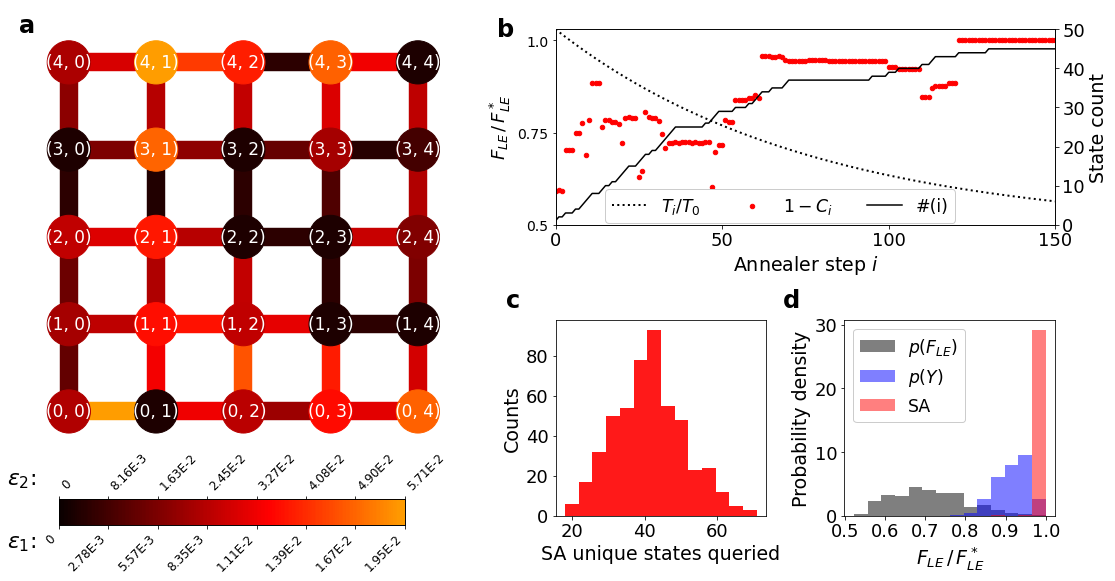

In [28]:
plt.style.use('../../style.mplstyle')

fig = plt.figure(figsize=(16, 8))

gs = fig.add_gridspec(4, 8)
ax0 = fig.add_subplot(gs[2:4, 4:6])
ax1 = fig.add_subplot(gs[2:4, 6:8])
ax2 = fig.add_subplot(gs[0:2, 4:8])
# ax3 = fig.add_subplot(gs[0:4, 0:4]) # jusut a dummy slot

tag = "contrived"
noise_graph = nx.read_gpickle(f"./results/{tag}_noisemap.pkl")
# Modify the weights so the plot looks nicer

# this is all trial and error:
axpos = [0.04, 0.2, 0.4, .8]
ax3 = fig.add_axes(axpos)
cbar_loc = [0.08, 0.1, 0.3, 0.045]
ax3, ax3b, ax3c = noisemap.plot_nn_graph_with_noise(noise_graph, noise_graph.nodes, ax=ax3, 
                                  metric_1q="weight", metric_2q="weight",
                                 show_values=False, nodescale=0.9, 
                                  nodefontscale=1.3, edgescale=.8,
                                  cbar_rect=cbar_loc, label_cbar=False)

fig.text(cbar_loc[0] - 0.045, cbar_loc[1] - 0.04, r"$\epsilon_1$:", size=22)
fig.text(cbar_loc[0] - 0.045, cbar_loc[1]+cbar_loc[3]*2 - 0.02, r"$\epsilon_2$:", size=22)
ax3.text(0.03, .96, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=ax3.transAxes, weight="bold")
ax3.axis('off')



best_score = max(metric_results[:,1])


# Subplot1 (ax1): annealer histories with temperature overlay
# best_score = max(metric_results[:,1])
# np.testing.assert_allclose(np.ones_like(anneal_outcomes[:,-1]), anneal_outcomes[:,-1] / best_score)

# Hide the axis xlabels like this was using sharex
avg_unq_states = np.average(anneal_unq_states)
ax0.hist(anneal_unq_states, color='r', alpha=0.9, bins=14)
# ax0.axvline(avg_unq_states, c='k', ls='--')
ax0.set_xlabel("SA unique states queried")
ax0.set_ylabel("Counts")

cts, bins, patches = ax1.hist(FLE / best_score, bins=14, color='k', label=r"$p(F_{LE})$", density=True, alpha=0.5)
cts, bins, patches = ax1.hist(found.flatten() / best_score, bins=bins, color='b', density=True, label=r"$p(Y)$", alpha=0.5)
cts, bins, patches = ax1.hist(np.max(anneal_outcomes, axis=1) / best_score, bins=bins, color='r', density=True, label=r"SA", alpha=0.5)

# ax1.axvline(1, c='r', lw=2)
# ax1.text(0.92, .5, r"simulated annealing", color='r', horizontalalignment='center', verticalalignment='center', size=14, transform=ax1.transAxes, rotation=90)

# ax1.legend(loc='upper left', framealpha=1, bbox_to_anchor=(1, 1))
ax1.legend(loc='upper left', framealpha=1, bbox_to_anchor=(0, 1))
ax1.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
ax1.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
ax1.set_xlabel(r"$F_{LE} \,/ \,F_{LE}^*$")
ax1.set_ylabel("Probability density")



i_good = 13
xvrange = np.arange(151)
ax2.scatter(xvrange, anneal_outcomes[i_good,xvrange] / best_score, s=80, marker='.', color='r', label=r"$1 - C_i$", alpha=1)
# ax2.set_xlim(-2, 150)
ax2.set_xticks(range(0, max(xvrange)+1, 50))
ax2.set_xlabel(r'Annealer step $i$')
ax2.set_xlim(0, max(xvrange))
ax2.set_ylim(min(FLE / best_score) * .98, 1.03)
ax2.set_yticks([.5, .75, 1.])
ax2.set_yticklabels([.5, .75, 1.], fontsize=14)
ax2.set_ylabel(r"$F_{LE} \,/ \,F_{LE}^*$", fontsize=18)

# overlay temperature in a nonsense kind of way
# that is, rescale so that its max and min correspond to the 
# ylim automatically imposed by the cost function plot
a, b = min(exp_temp), max(exp_temp)
c, d = ax2.get_ylim()
c = c * 0.98
ytemp = (exp_temp - a) / (b-a) * (d-c) + c
# ytemp = exp_temp + ax2.get_ylim()[0]
# ytemp = ytemp / max(ytemp)
ax2.plot(range(anneal_steps), ytemp , linewidth=2, c='k', ls=':', label=r"$T_i / T_0$")


# Plot anneal unq state progress on twinned axis
ax2b = ax2.twinx()
ax2b.plot(range(anneal_steps + 1), all_anneal_unq_states[i_good], c='k', label="#(i)")
ax2b.set_ylim(0, ax2b.get_ylim()[1])

lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
# ax2b.legend(lines2 + lines2b, labels2 + labels2b, framealpha=1, ncol=3, loc="lower center", bbox_to_anchor=(0.5, -0.05))
ax2b.legend(lines2 + lines2b, labels2 + labels2b, framealpha=1, ncol=3, loc="lower center", bbox_to_anchor=(0.45, -0.035))
ax2b.set_ylabel("State count")
ax2b.set_yticks(range(0, 60, 10))
# ax2b.set_yticklabels([0, 0.25, .5, .75, 1.], fontsize=14)


# ax2b.set_ylim(min(exp_temp), 1.08)

# ax2b.set_yticks([])
# ax2b.set_yticklabels([], fontsize=14)
# ax2b.legend(loc="center right")


# cAPTION
ax0.text(-0.2, 1.1, r"c", horizontalalignment='center', verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax1.text(-0.25, 1.1, r"d", horizontalalignment='center', verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
ax2.text(-0.1, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")

plt.tight_layout()
fig.savefig("../../figures/figure3.pdf",bbox_inches='tight')